# Infection Rate Calibration: Generate experiment parameter files

Based on a fixed network model, we sweep over the infection rate parameter $\beta$ to find the one that minimizes a point process distance between realizations of simulated processes and the real time series.

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

import os
import json
import random
import networkx as nx
from pprint import pprint

from lib.graph_generation import make_ebola_network
from lib.dynamics import SimulationSIR, PriorityQueue
from lib.dynamics import sample_seeds
from lib.settings import DATA_DIR, PROJECT_DIR

---

## Set parameters for the exeperiment

Experiment parameters

In [64]:
# Directory where the experiment should be located
exp_dir = os.path.join(PROJECT_DIR, 'output', 'calibration-beta-05to09-1')

Network parameters

In [65]:
n_nodes = 8000  # Desired number of nodes (we only keep the giant component, so actual number of nodes may be smaller)
p_in = 0.04  # Intra-district edge probability
p_out = p_in / 10  # Inter-district edge probability

num_nets = 10  # Number of networks to generate for the experiment
net_seed_list = [random.randint(0, 2**32) for i in range(num_nets)]  # Random seed for the generation of each network in the experiment (for reproducibility)

Epidemic parameters

In [67]:
# List of infection rates to experiment with
beta_range = 1 / np.linspace(10.0, 200.0, 13)

delta = 1 / 11.4  # Spontaneous recovery rate
gamma = 0.0  # Reduction in infectivity under treatement
rho = 0.0  # Increase of recovery under treatement

start_day_str = '2014-05-01'  # Start of epidemic (used to sample seeds from real data)
end_day_str = '2014-09-01'    # End of epidemic

Policy parameters

In [68]:
# Name of the treatement policy
policy_name = 'NO'  # We do not want any treatement for this experiment

# Policy parameters
policy_params = {}

### Set the parameter dict

Se the parameter dictionary based on the parameters defined above

In [69]:
param_dict = {
    'network': {
        'n_nodes': n_nodes,
        'p_in': p_in,
        'p_out': p_out,
        'seed': None, # Will be set for each job
    },
    'simulation': {
        'start_day_str': start_day_str,
        'end_day_str': end_day_str,
        'sir_params': {
            'beta': None,  # Will be set for each job
            'delta': delta,
            'gamma': gamma,
            'rho': rho,
        },
        'policy_name': policy_name,
        'policy_params': policy_params
    }
}

Visualize the dict (for sanity check)

In [70]:
pprint(param_dict, indent=2)

{ 'network': {'n_nodes': 8000, 'p_in': 0.04, 'p_out': 0.004, 'seed': None},
  'simulation': { 'end_day_str': '2014-09-01',
                  'policy_name': 'NO',
                  'policy_params': {},
                  'sir_params': { 'beta': None,
                                  'delta': 0.08771929824561403,
                                  'gamma': 0.0,
                                  'rho': 0.0},
                  'start_day_str': '2014-05-01'}}


Save all the parameter dicts for all the desired experiments

In [71]:
if not os.path.exists(exp_dir):
    print(f'Creat experiment directory: {exp_dir}')
    os.mkdir(exp_dir)
else:
    print('WARNING: Experiment directory already exists.\n')

# Iterate over networks
for net_idx in range(num_nets):
    
    # Set network seed
    param_dict['network']['seed'] = net_seed_list[net_idx]
   
    # Iterate over infection rates
    for beta_idx, beta in enumerate(beta_range):

        # Set beta
        param_dict['simulation']['sir_params']['beta'] = beta

        # Set file name
        filename = os.path.join(exp_dir, f"param-beta{beta_idx:0>3d}-net{net_idx:0>3d}.json")
        
        if os.path.exists(filename):
            raise Exception(f'File {filename} already exists... Abort!')

        with open(filename, 'w') as f:
            json.dump(param_dict, f)

Creat experiment directory: /Users/trouleau/Workspace/EPFL/research/ongoing/disease-control/disease-control/lib/../output/calibration-beta-05to09-1


---

### Validation of network parameters

Generate a graph from the parameters and check some properties of the graph

In [55]:
graph = make_ebola_network(**param_dict['network'])
A = nx.adjacency_matrix(graph).toarray()
n_nodes = graph.number_of_nodes()
print('Graph generated')
print(f"  - {graph.number_of_nodes()} nodes, {graph.number_of_edges()} edges")

Graph generated
  - 7991 nodes, 47990 edges


Check that the graph is connected

In [10]:
nx.is_connected(graph)

True

Visualize the node degree distribution

Mean: 13.17982587811468, Median: 11.0


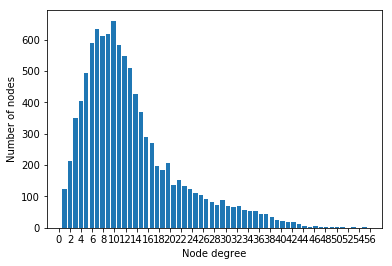

In [11]:
degree_sequence = [d for n, d in graph.degree()]
max_deg = max(degree_sequence)
print(f'Mean: {np.mean(degree_sequence)}, Median: {np.median(degree_sequence)}')
plt.hist(degree_sequence, bins=max_deg, rwidth=0.8, align='left')
plt.xlabel('Node degree')
plt.ylabel('Number of nodes')
plt.xticks(np.arange(0, max_deg+1, 2));

Visualize the graph diameter

In [12]:
def find_graph_diameter(graph, sample_size):
    """Compute an approximation of the graph diameter by sampling the maximum distance between nodes"""
    d = 0
    for u in np.random.choice(graph.nodes(), replace=False, size=sample_size):
        d_u = max(nx.shortest_path_length(graph, source=u).values())
        if d_u > d:
            d = d_u
    return d

diameter = find_graph_diameter(graph, sample_size=200)
print(f"Graph diameter is (approximately): {diameter:d}")

Graph diameter is (approximately): 21


Visualize the cluster size distribution

Minimum cluster size is: 24
Median cluster size is: 147
Average cluster size is: 181.69
Max cluster size is: 828


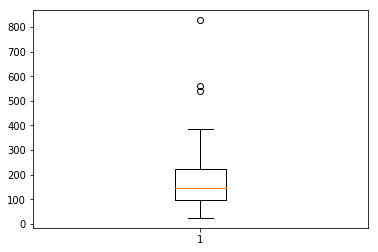

In [13]:
cluster_sizes = np.bincount([d['block'] for u,d in graph.nodes(data=True)])
plt.boxplot(cluster_sizes);
print(f"Minimum cluster size is: {min(cluster_sizes):d}")
print(f"Median cluster size is: {np.median(cluster_sizes):.0f}")
print(f"Average cluster size is: {np.mean(cluster_sizes):.2f}")
print(f"Max cluster size is: {np.max(cluster_sizes):d}")